In [127]:
import sys
import importlib as imp
if ('Jupytils' in sys.modules):
    reloaded = imp.reload(Jupytils)
else:
    import Jupytils
    
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
from sklearn import linear_model
from sklearn import cross_validation
from sklearn import ensemble
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
#from statsmodels.regression.quantile_regression import QuantReg
#import statsmodels.formula.api as smf
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

han1="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20patient_data_table";
hand="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20hand"
kimj="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kimj";
leeh="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20leeh";
sony="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20sony";
kuky="http://www.smartconnectedhealth.org/aura/webroot/db.jsp?q=SELECT%20*%20FROM%20kuky";

fileName = hand;

dfOriginal = LoadDataSet(fileName, checkForDateTime=False);
displayDFs (dfOriginal, maxrows=13 );
#for c in dfOriginal.columns: print (c,  end=', ')

<IPython.core.display.Javascript object>

In [128]:
df=dfOriginal.copy()

#1. Remove all the rows that does not have any pef values 
df.insert(4, 'npt',0)
df.insert(4, 'pef',0)
df.npt = pd.notnull(df.pef1)*1 + pd.notnull(df.pef2)*1 + pd.notnull(df.pef3)*1
df = df[df.npt > 0]
df=df.reset_index(drop=True)
df.pef = (df.pef1 + df.pef2 + df.pef3)/df.npt

#2. Combine 
df=df.fillna(0)
df.loc[df.timeofday == 'null', 'timeofday'] = "00:00:00"
sdttm = df.dateofmeasure + " " + df.timeofday 
df.insert(0, 'sdttm', sdttm)
df.sdttm = pd.to_datetime(df.sdttm)

df.sort_values(by='sdttm', ascending=True, inplace=True)
drps  = "cname, ampm, timeofday, dateofmeasure, npt, pef1, pef2, pef3, pef, indexpef".split(', ')
df=df.drop(drps, axis=1, errors='ignore')
df=df.reset_index(drop=True)

## <== do the following for SAP PA tool
#pef = df.pef;
#df=df.drop(['pef'], axis=1)
#df.insert(1, 'pef1', pef)

#pef[-10:]=0     # Set last 10 to zero for predictions
#df.insert(1, 'pef', pef)
#df.to_csv("HanD/hand1.csv", sep=';')

df1 = df.copy()
df1 = df1.set_index(df1.sdttm.values)
df1=df1.drop('sdttm', axis=1, errors='ignore')

#s= pd.qcut(df1.pefmax, 10, labels='a1,a2,a3,a4,a5,a6,a7,a8,a9,a10'.split(','))
nq = 3
lnq=list(range(0,nq))
#s= pd.qcut(df1.pefmax, nq, labels='0,1,2,3,4,5,6,7,8,9'.split(','))
s= pd.qcut(df1.pefmax, nq, labels=lnq )
df1.insert(1,"pefcat", s)
df1.pefcat = df1.pefcat.astype(str)

columns = '''pefmax,pefcat,so2,co,o3,no2,windspeedms,precipitationpercent,airpressurehpa,tmax,amax'''
#amin,pmin,tmaxlesstmin,amaxlessamin,pmaxlesspmin'''
cs = [c.strip() for c in columns.split(',')]

df1=df1[cs]
#HTML(df1.to_html())
displayDFs (df1, maxrows=3 )
;

''

In [3]:
%run "../../PyUtils/common.ipynb"
A=np.zeros( (nq,nq))
t = df1['pefcat'].astype(int)

last = -1;
for ii,jj in enumerate(t):
    jj = int(jj)
    if ( last < 0 ):
        last = jj
        continue;
    A[last, jj] = A[last,jj] + 1
    last = jj;
#    if ( ii < 20):
#        print (last, ii, jj, m[last, jj])
A1=A
A=A1/A1.sum(axis=1)[:, np.newaxis]
A=np.matrix(A)
LA.display(A, A1)


<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

In [4]:
##Another way to compute the matrix
##
df2 = df1[['pefcat']].copy()
df2.insert(1, column='p', value=0)
df2.columns=['a','b']
b= list(df2.a[1:])
b.append('0')
df2.b=b
m=pd.crosstab(df2.a, df2.b, normalize='index').as_matrix()
m=np.matrix(m)
print ("matrix: ", m, "\n First few values of t", t[0:24].values)

matrix:  [[ 0.5494  0.3229  0.1277]
 [ 0.3415  0.3976  0.261 ]
 [ 0.1237  0.2912  0.5851]] 
 First few values of t [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 0 1 1]


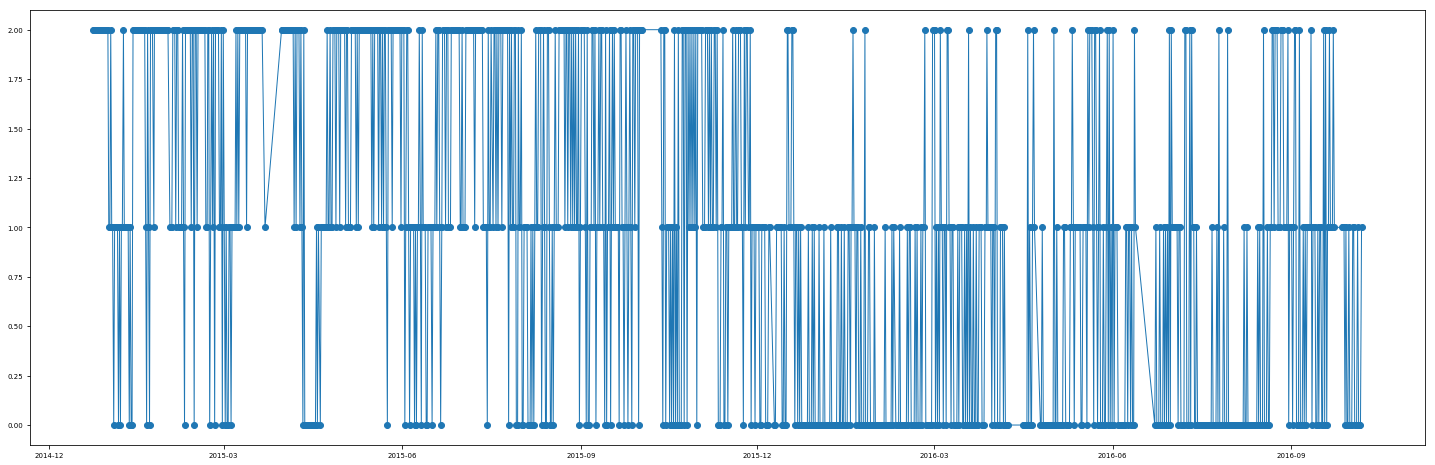

In [5]:
plt.figure(figsize=(25, 8))
plt.plot( df1.index, t, marker='o')

In [6]:
print ("matrix: \n", m, "\n First few values of t\n--------------", t[0:24].values)

pi=np.matrix([1.,0.,0.])
si=m
sp=pi
lists=[[pi]]
for i in range(4):
    si=sp*m
    mr = m ** (i+1)
    sii= pi * mr;
    print ("%4d %18s %22s %18s %20s"%(i, pi, sp, si, sii))
    sp = si
    lists.append([si])

lists = np.matrix(  vstack([lists]))
lists  
    

matrix: 
 [[ 0.5494  0.3229  0.1277]
 [ 0.3415  0.3976  0.261 ]
 [ 0.1237  0.2912  0.5851]] 
 First few values of t
-------------- [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 1 1 0 1 1]
   0    [[ 1.  0.  0.]]        [[ 1.  0.  0.]] [[ 0.5494  0.3229  0.1277]] [[ 0.5494  0.3229  0.1277]]
   1    [[ 1.  0.  0.]] [[ 0.5494  0.3229  0.1277]] [[ 0.4279  0.343   0.2291]] [[ 0.4279  0.343   0.2291]]
   2    [[ 1.  0.  0.]] [[ 0.4279  0.343   0.2291]] [[ 0.3805  0.3412  0.2782]] [[ 0.3805  0.3412  0.2782]]
   3    [[ 1.  0.  0.]] [[ 0.3805  0.3412  0.2782]] [[ 0.36    0.3396  0.3004]] [[ 0.36    0.3396  0.3004]]


matrix([[ 1.    ,  0.    ,  0.    ],
        [ 0.5494,  0.3229,  0.1277],
        [ 0.4279,  0.343 ,  0.2291],
        [ 0.3805,  0.3412,  0.2782],
        [ 0.36  ,  0.3396,  0.3004]])

In [8]:
A=np.zeros( (nq,nq))
t = df1['pefcat'].astype(int)

last = -1;
for ii,jj in enumerate(t):
    jj = int(jj)
    if ( last < 0 ):
        last = jj
        continue;
    A[last, jj] = A[last,jj] + 1
    last = jj;
#    if ( ii < 20):
#        print (last, ii, jj, m[last, jj])
A1=A
A=A1/A1.sum(axis=1)[:, np.newaxis]
A=np.matrix(A)
LA.display(A, A1)


<IPython.core.display.Math object>

In [45]:
# Example From Paper

price='''
5 5 5 5 4 5 3 5 3 3 4 2 5 5 3 1 1 1 3 3 4 1 5 1 1 3 3 2 5 1 5 1 5 5 5 5 2 1 4 1 1 1 2 4 5 5 1 4 2 4 1 3 4 2 2 5 2 2 5 5 
2 5 4 4 4 2 2 5 2 2 5 5 5 5 3 2 2 5 4 5 2 4 5 5 4 1 1 1 2 2 3 2 4 5 5 5 2 5 2 5 5 2 4 2 5 5 2 5 5 1 2 3 4 3 3 1 3 1 4 3
5 4 5 5 4 5 5 2 5 2 5 2 2 3 5 5 3 5 2 5 4 2 1 5 2 5 2 2 2 2 5 5 4 5 5 2 2 5 2 2 2 3 4 4 4 5 4 5 1 5 5 1 3 5 5 5 1 5 2 2
2 5 5 5 5 2 4 5 2 2 5 2 5 2 2 2 4 2 2 2 4 5 5 5 3 2 2 5 2 5 4 4 4 5 3 3 5 3 1 1 4 2 2 5 5 2 5 5 5 2 5 5 3 5 5 4 1 5 5 1
5 5 1 5 1 5 5 5 5 1 5 5 5 2 1 2 5 2 5 5 2 3 5 5 5 5 5 2 5''' 

sales='''
5 1 1 1 1 2 2 3 3 3 4 3 2 2 5 1 5 5 1 2 3 3 2 3 3 2 2 1 1 5 2 3 3 3 3 2 3 1 2 1 1 5 2 2 5 5 2 3 4 3 4 2 2 1 5 5 1 5 1 5
5 1 1 5 3 3 3 3 3 3 4 3 3 5 1 5 5 1 1 5 1 5 5 1 5 5 1 5 5 1 5 1 5 2 3 3 3 3 3 3 3 5 1 5 5 1 5 1 5 5 5 5 1 5 1 1 5 3 3 3
3 3 3 5 2 2 5 1 1 1 5 1 5 1 1 1 1 1 1 1 1 1 1 1 1 2 5 3 4 4 4 4 1 3 5 5 1 5 5 1 1 5 1 1 1 1 5 1 2 1 1 2 5 2 1 1 2 3 3 3
3 4 4 3 2 2 5 1 5 1 1 1 5 2 1 1 1 1 4 4 3 3 3 3 2 5 1 5 5 1 5 1 5 1 1 2 2 3 3 4 3 3 1 1 1 2 1 1 5 1 1 1 5 1 1 1 1 1 1 1
2 3 3 1 1 4 3 1 3 2 1 1 1 1 1 5 5 1 5 1 5 1 1 1 1 1 1 1'''

p = [int(c) for c in price.replace('\n', ' ').strip().split()]
s = [int(c) for c in sales.replace('\n', ' ').strip().split()]
#print(len(p), ":", p,"\n\n", len(s),":", s)
print(len(p), ":", p)

np.set_printoptions(precision=4)
t=np.array(p)
nq=len(np.unique(t))
A=np.zeros( (nq,nq))

last = t[0]-1;
for ii,jj in enumerate(t[1:]):
    jj = int(jj) -1;
    A[jj, last] = A[jj, last] + 1
    last = jj;
A1=A
A=A1/A1.sum(axis=1)[:, np.newaxis]
AA=A1/((A1.sum(axis=0)[np.newaxis,:]))
A=np.matrix(A)

#Stationary distribution
g=sum(A1.sum(axis=1))
A2=np.matrix(A1.sum(axis=0)/g)
print(A2, "\n\n", A**300, "\n\n")

#Want
w='''
0.2917 0.0370 0.1500 0.1429 0.1096
0.1250 0.3704 0.1500 0.2500 0.3014
0.2083 0.0741 0.2000 0.0714 0.0685
0.1250 0.1296 0.2500 0.1429 0.1233
0.2500 0.3889 0.2500 0.3929 0.3973
'''
w=np.matrix([float(c) for c in re.split('[\s]+',w.replace('\n', ' ').strip())]).reshape((5,5))
#print( "\n\n", w**450, "\n\n")
#T x [0.1200 0.2750 0.1000 0.1400 0.3650] ˆ =

LA.display(A, AA, A1, w)


269 : [5, 5, 5, 5, 4, 5, 3, 5, 3, 3, 4, 2, 5, 5, 3, 1, 1, 1, 3, 3, 4, 1, 5, 1, 1, 3, 3, 2, 5, 1, 5, 1, 5, 5, 5, 5, 2, 1, 4, 1, 1, 1, 2, 4, 5, 5, 1, 4, 2, 4, 1, 3, 4, 2, 2, 5, 2, 2, 5, 5, 2, 5, 4, 4, 4, 2, 2, 5, 2, 2, 5, 5, 5, 5, 3, 2, 2, 5, 4, 5, 2, 4, 5, 5, 4, 1, 1, 1, 2, 2, 3, 2, 4, 5, 5, 5, 2, 5, 2, 5, 5, 2, 4, 2, 5, 5, 2, 5, 5, 1, 2, 3, 4, 3, 3, 1, 3, 1, 4, 3, 5, 4, 5, 5, 4, 5, 5, 2, 5, 2, 5, 2, 2, 3, 5, 5, 3, 5, 2, 5, 4, 2, 1, 5, 2, 5, 2, 2, 2, 2, 5, 5, 4, 5, 5, 2, 2, 5, 2, 2, 2, 3, 4, 4, 4, 5, 4, 5, 1, 5, 5, 1, 3, 5, 5, 5, 1, 5, 2, 2, 2, 5, 5, 5, 5, 2, 4, 5, 2, 2, 5, 2, 5, 2, 2, 2, 4, 2, 2, 2, 4, 5, 5, 5, 3, 2, 2, 5, 2, 5, 4, 4, 4, 5, 3, 3, 5, 3, 1, 1, 4, 2, 2, 5, 5, 2, 5, 5, 5, 2, 5, 5, 3, 5, 5, 4, 1, 5, 5, 1, 5, 5, 1, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 2, 1, 2, 5, 2, 5, 5, 2, 3, 5, 5, 5, 5, 5, 2, 5]
[[ 0.1194  0.25    0.097   0.1269  0.4067]] 

 [[ 0.1194  0.25    0.097   0.1269  0.4067]
 [ 0.1194  0.25    0.097   0.1269  0.4067]
 [ 0.1194  0.25    0.097   0.1269  0.4067]
 [ 0.1194 

<IPython.core.display.Math object>

In [54]:
ww=AA
for i in range(5):
    print(ww[:,i], ww[i,:], sum(ww[:,i]),  sum(ww[i,:]) )

[ 0.25    0.125   0.1562  0.125   0.3438] [ 0.25    0.0448  0.1538  0.1471  0.1101] 1.0 0.705772839898
[ 0.0448  0.3284  0.0746  0.1194  0.4328] [ 0.125   0.3284  0.1538  0.2353  0.2661] 1.0 1.10855352632
[ 0.1538  0.1538  0.1923  0.1923  0.3077] [ 0.1562  0.0746  0.1923  0.0588  0.0826] 1.0 0.564576894731
[ 0.1471  0.2353  0.0588  0.1765  0.3824] [ 0.125   0.1194  0.1923  0.1765  0.1009] 1.0 0.71409869681
[ 0.1101  0.2661  0.0826  0.1009  0.4404] [ 0.3438  0.4328  0.3077  0.3824  0.4404] 1.0 1.90699804224


In [126]:
a=p
for (x,y), c in Counter(zip(a, a[1:])).items():
    b[y-1,x-1] = c
b

array([[  8.,   3.,   4.,   5.,  12.],
       [  4.,  22.,   4.,   8.,  29.],
       [  5.,   5.,   5.,   2.,   9.],
       [  4.,   8.,   5.,   6.,  11.],
       [ 11.,  29.,   8.,  13.,  48.]])

[('a', 'b', 'a'), ('b', 'a', 'b'), ('a', 'b', 's')]